In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

#import missingno 

In [3]:
pd.options.display.max_rows = 999

In [4]:
# Database connection
import mysql.connector



con = mysql.connector.connect(host=host, database=database, user=user, password=password)

#table = ‘platform_market_prices2’

data = pd.read_sql("SELECT * FROM platform_market_prices2", con=con)

con.close()

In [5]:
df = data.sort_values(by='date')
pd.to_datetime(df['date'])
df.head()

,id,source,country,market,product_cat,product_agg,product,date,retail,wholesale,currency,unit,active,udate
54889,386128,EAGC-RATIN,KEN,Nairobi,Cereals - Other,Barley,Barley,2013-05-29,46,42,KES,1Kg,1,2019-04-23 09:44:08
55710,386980,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-17,47,33,KES,1Kg,1,2019-04-23 09:45:58
56090,387375,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-20,47,33,KES,1Kg,1,2019-04-23 09:46:46
44955,383515,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-24,45,33,KES,1Kg,1,2019-04-20 10:41:52
76217,413249,EAGC-RATIN,TZA,Arusha,Cereals - Rice,Rice,Morogoro Rice,2014-08-20,91,75,KES,1Kg,1,2019-07-15 06:42:57


In [6]:
len_p = len(df['product_agg'].unique())
len_m = len(df['market'].unique())
len_s = len(df['source'].unique())
print(f'Unique product, market, and source, respectively: {len_p}, {len_m}, {len_s}')
print(f'Number of combinations: {len_p*len_m*len_s}')

Unique product, market, and source, respectively: 64, 200, 8
Number of combinations: 102400


In [7]:
# construct complete time frame
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
time_df = pd.DataFrame([], index=date_range)
time_df.tail()

""
2019-10-24
2019-10-25
2019-10-26
2019-10-27
2019-10-28


In [8]:
# check for completeness, single time series
PRODUCT = 'Rice'
MARKET = 'Gitega'
SOURCE = 'EAGC-RATIN'

subset_single = df[(df['product_agg']==PRODUCT) & (df['market']==MARKET) & (df['source']==SOURCE)].sort_values('date').set_index('date')
subset_single.head()

,id,source,country,market,product_cat,product_agg,product,retail,wholesale,currency,unit,active,udate
date,,,,,,,,,,,,,
2013-06-17,386980,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,47,33,KES,1Kg,1,2019-04-23 09:45:58
2013-06-20,387375,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,47,33,KES,1Kg,1,2019-04-23 09:46:46
2013-06-24,383515,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,45,33,KES,1Kg,1,2019-04-20 10:41:52
2018-05-31,382014,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Imported Rice,167,161,KES,1Kg,1,2019-04-20 10:40:09
2018-06-07,383356,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Imported Rice,172,166,KES,1Kg,1,2019-04-20 10:41:41


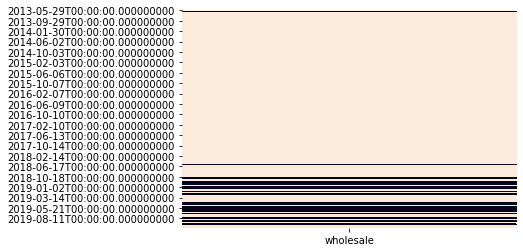

In [9]:
subset_single = time_df.merge(subset_single[['wholesale']], how='left', left_index=True, right_index=True)

new_colname = PRODUCT+'_'+MARKET+'_'+ SOURCE
new_set = subset_single.rename(columns={'wholesale':new_colname})

ax = sns.heatmap(subset_single.isnull(), cbar=False)
#ax.set_yticklabels(new_set.index.strftime('%Y/%m/%d'))
# how to change y-axis date format??
plt.show()

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(new_set, title='Profile report', explorative=True)
# pandas profile not very useful here
dir(profile)
profile.to_file("Profile_wholesale_x.html")

In [11]:
# select multple markets, products and sources

"""
Dry maize in Kampala (or UGA), will be very different from others (supplier market)
Dry Maize in Nairobi (or KEN) will be differnet (consumption market)
Black Beans in Rwanda are going to be different from the others
Millet Grain in UGA
Yellow beans in TZA
An Animal product (which ever has data) will likely have different seasonality
Peas are not a food staple in the region, but has a lot of data so that will be important
A fruit will also be important, but that could be based on data availabiltiy"""


# #Lance's list for distinct product
# PRODUCT_LIST = ['Dry maize', 'Beans', 'Black Beans (Dolichos)', 'Millet', 'Peas'] 


# # Top product list (more than 1000 samples are available)
# # This should be the good quality for machine learning
# cond = (df['product'].value_counts()>1000)
# PRODUCT_LIST = [i for i in cond.index if cond[i]==True]
# len(PRODUCT_LIST)

# All product list
PRODUCT_LIST = df['product'].unique().tolist()

# # Top market list (more than 1000 samples are available)
# cond = (df['market'].value_counts()>1000)
# MARKET_LIST = [i for i in cond.index if cond[i]==True]
# len(MARKET_LIST)

MARKET_LIST = df['market'].unique().tolist()

# source list
SOURCE_LIST = df['source'].unique().tolist()

In [27]:
# data quality table

# create a summarize table for data quality
col_names = ['market', 'product', 'source', 'start', 'end', 'timeliness', 'data_length', 'completeness', 'duplicates', 'mode_D']
""" definitions:
    start: start of time series
    end: end of time seires
    timeliness: gap between the end of time seires and today, days
    data_length: length of available data in terms of days
    completeness: not NaN/total data
    duplicates: number of data sampled on same date
    mode_D: the most frequent sampling interval in time series, days
    
    
    """
m = len(MARKET_LIST)*len(PRODUCT_LIST)*len(SOURCE_LIST)
n = len(col_names)

anticipated_QC_size = m*n

QC = [[] for _ in range(m)]
i = 0
for MARKET in MARKET_LIST:
    for PRODUCT in PRODUCT_LIST:
        for SOURCE in SOURCE_LIST:
            
            # apply filters
            cond1 = (df['product_agg']==PRODUCT)
            cond2 = (df['source']==SOURCE)
            cond3 = (df['market']==MARKET)
            sale_type = 'retail'
            
            subset = df[cond1 & cond2 & cond3].sort_values('date').set_index('date')
            
            # this is the sale time series
            sale = subset[[sale_type]] 
            
            if sale.empty:
                break
            
            else:
                
                # construct time frame and create augumented time series 
                START, END = sale.index.min(), sale.index.max()
                TIMELINESS = (datetime.now()-END).days
                
                # construct a time frame from start to end
                date_range = pd.date_range(start=START, end=END, freq='D')
                time_df = pd.DataFrame([], index=date_range)  

                sale_time = time_df.merge(sale, how='left', left_index=True, right_index=True)

                # completeness
                L = len(sale_time)
                L_nan = sale_time.isnull().sum()
                COMPLETENESS = (1-L_nan/L)[0]
                COMPLETENESS = round(COMPLETENESS, 3)
                DATA_LEN = L
                
                if COMPLETENESS ==0 | DATA_LEN==1:
                    # no data or 1 datum
                    DUPLICATES = np.nan
                    MODE_D = np.nan
                
                              
                else: 
                    # some data exist
                    # This decide the difference of sampling date
                    timediff = pd.DataFrame(np.diff(sale.index.values), columns=['D'])
                    x = timediff['D'].value_counts()
                    x.index = x.index.astype(str)
                    
                    if len(x)==1 & any(x.index=='0 days'):
                        # all data has same date
                        DUPLICATES = x[0]
                        MODE_D = np.nan
                        
                    elif len(x)==1 & ~any(x.index=='0 days'):
                        # all data equally spaced  
                        DUPLICATES = np.nan
                        MODE_D = x[0]                     
                 
                    elif any(x.index=='0 days') & len(x)>1:
                        # duplication exists and data not equally spaced                
                        DUPLICATES = x[x.index=='0 days'][0]
                        MODE_D = x[~(x.index =='0 days')][0]
                         
                    else:
                        # no duplication 
                        DUPLICATES = 0
                        MODE_D = x[0]    
                        
                START = str(START.date())
                END = str(END.date())
                QC_i = [MARKET, PRODUCT, SOURCE, START, END, TIMELINESS, DATA_LEN, COMPLETENESS, DUPLICATES, MODE_D]
                
                QC[i] = QC_i
                i = i+1

#print(f"DATA QC Meta data size: {QC.itemsize} bytes")
# write to DQ dataframe
QC_df = pd.DataFrame(columns=col_names, data = QC)


In [28]:
QC_df.describe()

,timeliness,data_length,completeness,duplicates,mode_D
count,312.000000,312.000000,312.000000,298.000000,296.000000
mean,288.426282,461.644231,0.433532,0.030201,123.584459
std,114.113701,434.571340,0.217869,0.237326,183.250943
min,216.000000,1.000000,0.007000,0.000000,1.000000
25%,217.000000,136.750000,0.287750,0.000000,25.750000
50%,232.000000,359.000000,0.409000,0.000000,67.000000
75%,329.250000,624.500000,0.547250,0.000000,118.250000
max,975.000000,2626.000000,1.000000,3.000000,1392.000000


In [29]:
len(QC_df)

283200

In [30]:
QC_df.head(10)

,market,product,source,start,end,timeliness,data_length,completeness,duplicates,mode_D
0,Nairobi,Barley,EAGC-RATIN,2013-05-29,2018-06-14,706.0,1843.0,0.007,0.0,4.0
1,Nairobi,Beans,EAGC-RATIN,2016-06-23,2019-10-11,222.0,2598.0,0.623,0.0,1392.0
2,Nairobi,Peas,EAGC-RATIN,2018-01-04,2019-10-11,222.0,1282.0,0.683,0.0,636.0
3,Nairobi,Rice,EAGC-RATIN,2015-12-02,2019-07-25,300.0,1521.0,0.224,0.0,189.0
4,Nairobi,Wheat,EAGC-RATIN,2018-01-16,2019-07-25,300.0,683.0,0.328,0.0,127.0
5,Nairobi,Maize,EAGC-RATIN,2018-12-13,2019-10-11,222.0,357.0,0.524,0.0,78.0
6,Nairobi,Sorghum,EAGC-RATIN,2018-09-10,2019-10-11,222.0,583.0,0.619,0.0,186.0
7,Nairobi,Millet,EAGC-RATIN,2018-09-06,2019-10-09,224.0,444.0,0.423,0.0,83.0
8,Gitega,Beans,EAGC-RATIN,2018-10-11,2019-10-16,217.0,884.0,0.777,0.0,513.0
9,Gitega,Peas,EAGC-RATIN,2018-01-04,2019-10-16,217.0,1120.0,0.646,0.0,469.0


In [41]:
QC_df.sort_values(by=['mode_D'], ascending=True).sort_values(by='completeness', ascending=False)

,market,product,source,start,end,timeliness,data_length,completeness,duplicates,mode_D
311,Kigali,Beans,EAGC-RATIN,2019-08-20,2019-08-20,275.0,1.0,1.0,NaN,NaN
169,Machakos,Sorghum,EAGC-RATIN,2019-09-04,2019-09-04,259.0,2.0,1.0,1.0,NaN
95,Meru,Wheat,EAGC-RATIN,2019-09-18,2019-09-18,245.0,1.0,1.0,NaN,NaN
99,Dodoma,Barley,EAGC-RATIN,2019-03-15,2019-03-15,432.0,2.0,1.0,1.0,NaN
106,Mwanza,Peas,ACE Malawi/RATIN,2017-09-18,2017-09-18,975.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
283195,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
283196,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
283197,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
283198,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN


In [31]:
QC_df.dropna(axis=0, how='all')
len(QC_df)

283200

In [32]:
# save a copy of cleaned data to csv
savePath = '../data/'
filename = 'QC_'+sale_type
fileformat = '.csv'
df.to_csv(savePath+filename+fileformat, index=False)

In [33]:
# save to db file
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../data/mydb.db', echo=False)
df.to_sql(filename, con=engine, if_exists='replace')

KeyboardInterrupt: 

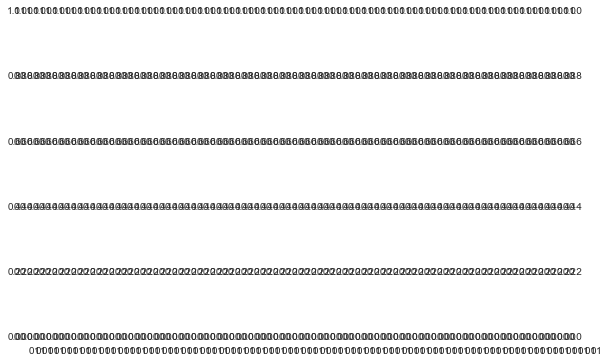